## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import tikzplotlib

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_predict, validation_curve, learning_curve

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.compose import TransformedTargetRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import validation_curve

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer, r2_score

from utils.preprocessing import preprocess_duplicated_and_missing, preprocess_duplicated_and_missing_test_set, preprocess_irrelevant_features, one_hot_encode_genres_feature, one_hot_encode_studio_feature, remove_outliers, other_fixes, standardize, standardize2
from utils.feature_extraction import extract_embeddings_features, pca_on_embeddings
from utils.feature_selection import get_mutual_information_matrix, normalize_mutual_information_matrix, select_features_MI_kbest, mrmr, select_features_RFECV
from utils.model_selection import linreg, ModelSelection
from utils.plots import plot_correlation_matrix, plot_mutual_information_matrix, plot_mutual_information_with_target, plot_predictions

from utils.latex import set_size, set_size_square_plot

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [2]:
# declare variables for model selection
N_SPLITS = 5

kf = KFold(n_splits=N_SPLITS)
rmse = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

In [3]:
pd.set_option('display.max_columns', 50)

## Load datasets

In [4]:
def read_datasets():
	X1 = pd.read_csv("datasets/X1.csv", na_values="\\N")
	Y1 = pd.read_csv("datasets/Y1.csv", header=None, names=["revenues"])
	X2 = pd.read_csv("datasets/X2.csv", na_values="\\N")

	X1.drop("Unnamed: 0", axis=1, inplace=True)
	X2.drop("Unnamed: 0", axis=1, inplace=True)
	df = pd.concat([X1, Y1], axis = 1)

	print(f"X1 dataset contains {X1.shape[0]} observations and {X1.shape[1]} features")
	print(f"X2 dataset (for prediction only) contains {X2.shape[0]} observations")

	return df, X2

## Preprocessing

In [5]:
def preprocess(df, train, X2, dataset_name):
	print("-" * 25)
	print(f"PREPROCESSING {dataset_name}...")
	print("-" * 25)
	# remove duplicated observations and preprocessing missing values
	df = preprocess_duplicated_and_missing(df, train)
	# should not remove duplicated and missing values from X2
	# as Y2.csv should contains 1518 predictions
	# impute missing values insted
	X2 = preprocess_duplicated_and_missing_test_set(X2, train)

	# remove (obvious) irrelevant/redundant features
	df = preprocess_irrelevant_features(df)
	X2 = preprocess_irrelevant_features(X2)

	# fix high-cardinality + one-hot-encode studio feature
	df, X2 = one_hot_encode_studio_feature(df, X2)

	# one-hot encode genres feature
	df, X2 = one_hot_encode_genres_feature(df, X2)

	# minor fixes
	df = other_fixes(df)
	X2 = other_fixes(X2)
	return df, X2

## Feature extraction and dimension reduction

In [6]:
def remove_outliers_and_split(X, Y):
	print("-" * 25)
	print("REMOVING OUTLIERS AND TRAIN-TEST SPLIT...")
	print("-" * 25)

	X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8, test_size = 0.2, shuffle = True, random_state = 42)

	print(f"training dataset dimension: X_train: {X_train.shape}, y_train: {y_train.shape}")
	print(f"testing dataset dimension: X_test: {X_test.shape}, y_test: {y_test.shape}")

	# remove outliers only on train set
	# as test set should be representative of the reality
	#X_train, y_train = remove_outliers(X_train, y_train, ["runtime", "production_year", "release_year"])

	return X_train, y_train, X_test, y_test

def extract_features(X_train, y_train, X_test, y_test, X2, run_pca=True, non_linear=True):
	print("-" * 25)
	print("FEATURE EXTRACTION...")
	print("-" * 25)

	# extract feature vectors
	X_train_img_embeddings = extract_embeddings_features(X_train["img_embeddings"])
	X_test_img_embeddings = extract_embeddings_features(X_test["img_embeddings"])

	X_train_text_embeddings = extract_embeddings_features(X_train["text_embeddings"])
	X_test_text_embeddings = extract_embeddings_features(X_test["text_embeddings"])

	# should also extract features for X2
	X2_img_embeddings = extract_embeddings_features(X2["img_embeddings"])
	X2_text_embeddings = extract_embeddings_features(X2["text_embeddings"])

	X_train_img_df, X_test_img_df, X2_img_df = pca_on_embeddings(X_train_img_embeddings, X_test_img_embeddings, X2_img_embeddings, X_train.index, X_test.index, X2.index, prefix="img_feature", n_components=5, run_pca=run_pca, non_linear=non_linear)

	X_train_text_df, X_test_text_df, X2_text_df = pca_on_embeddings(X_train_text_embeddings, X_test_text_embeddings, X2_text_embeddings, X_train.index, X_test.index, X2.index, prefix="text_feature", n_components=5, run_pca=run_pca, non_linear=non_linear)

	# drop unnecessary features
	X_train.drop(["img_embeddings", "text_embeddings"], axis=1, inplace=True)
	X_test.drop(["img_embeddings", "text_embeddings"], axis=1, inplace=True)
	X2.drop(["img_embeddings", "text_embeddings"], axis=1, inplace=True)

	# standardize other features
	X_train, X_test, X2 = standardize2(X_train, X_test, X2)

	X_train = pd.concat([X_train, X_train_img_df, X_train_text_df], axis=1)
	X_test = pd.concat([X_test, X_test_img_df, X_test_text_df], axis=1)
	X2 = pd.concat([X2, X2_img_df, X2_text_df], axis=1)


	return X_train, y_train, X_test, y_test, X2

## Model

In [7]:
df, X2 = read_datasets()

train_set = df

# preprocessing 
df, X2 = preprocess(df, train_set, X2, "modeling and prediction datasets")

X1 dataset contains 3540 observations and 13 features
X2 dataset (for prediction only) contains 1518 observations
-------------------------
PREPROCESSING modeling and prediction datasets...
-------------------------
[X] Removing duplicated and missing values
[X] impute missing values (X2 set)
[X] Removing irrelevant features
[X] Removing irrelevant features
[X] One-Hot encoding studio feature
[X] One-Hot encoding genres feature
[X] Minor fixes
[X] Minor fixes


In [8]:
df

,ratings,n_votes,production_year,runtime,release_year,img_embeddings,text_embeddings,revenues,studio_other,studio_MGM,studio_NL,studio_IFC,studio_Mira.,studio_Uni.,studio_Fox,studio_BV,studio_Par.,studio_WB,studio_Magn.,studio_Strand,studio_SPC,studio_Lions,studio_Orion,studio_Col.,studio_Gold.,...,genre_Comedy,genre_Romance,genre_Crime,genre_Action,genre_Adventure,genre_Documentary,genre_Thriller,genre_Family,genre_Mystery,genre_Fantasy,genre_Horror,genre_Animation,genre_Biography,genre_Music,genre_Sci-Fi,genre_History,genre_Sport,genre_War,genre_Short,genre_Western,genre_Musical,genre_Reality-TV,genre_Game-Show,genre_News,genre_Film-Noir
0,6.5,11.439677,2010,105.000000,2010,"[0.25030804, 2.4058464, 1.0431569, 0.030648155...","[-0.6795498, 0.35658365, 0.9994932, -0.9793934...",7.158530e+07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7.9,2.397895,1996,93.360764,2014,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722...",8.964834e+04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5.9,7.204149,1978,127.000000,1978,"[0.18073043, 0.24735461, 0.63652813, 0.2496522...","[-0.709996, 0.4233521, 0.99980927, -0.98892415...",3.164907e+07,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,6.6,8.486940,1994,105.000000,1994,"[0.025015268, 0.9105338, 0.3878257, 0.3421247,...","[-0.7416838, 0.38435012, 0.9998453, -0.9874693...",3.898197e+07,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
4,4.1,6.308098,1982,108.000000,1982,"[0.19079691, 1.9068279, 0.29114372, 0.19527505...","[-0.65501904, 0.3845747, 0.9996712, -0.9766391...",9.697023e+06,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3533,5.8,6.082219,2004,92.000000,2004,"[0.11425325, 1.0173515, 0.6975882, 0.18909442,...","[-0.781755, 0.49013087, 0.99993354, -0.9907543...",2.700968e+05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3534,6.9,8.338306,2008,110.000000,2008,"[0.37097943, 3.1644535, 0.24232517, 0.16169561...","[-0.5455457, 0.3419857, 0.999181, -0.96788496,...",1.563752e+04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3537,7.6,3.526361,2001,44.000000,2000,"[0.15014637, 2.0139444, 1.0844889, 0.17270318,...","[-0.61463475, 0.4013893, 0.99981415, -0.985390...",2.677043e+06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3538,7.5,10.217532,2006,98.000000,2006,"[0.25391683, 3.8994913, 0.23327282, 0.17322594...","[-0.74685824, 0.43955636, 0.99979496, -0.98784...",4.480911e+05,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
# spliting input and target
X = df.drop("revenues", axis=1)
Y = df["revenues"]

# remove outliers and train-test split
X_train, y_train, X_test, y_test = remove_outliers_and_split(X, Y)

# extract features + standardize (and pca)
X_train, y_train, X_test, y_test, X2 = extract_features(X_train, y_train, X_test, y_test, X2, run_pca=True, non_linear=False)

-------------------------
REMOVING OUTLIERS AND TRAIN-TEST SPLIT...
-------------------------
training dataset dimension: X_train: (2484, 54), y_train: (2484,)
testing dataset dimension: X_test: (621, 54), y_test: (621,)
-------------------------
FEATURE EXTRACTION...
-------------------------


extracting features:   0%|          | 0/2484 [00:00<?, ?it/s]

extracting features:   0%|          | 0/621 [00:00<?, ?it/s]

extracting features:   0%|          | 0/2484 [00:00<?, ?it/s]

extracting features:   0%|          | 0/621 [00:00<?, ?it/s]

extracting features:   0%|          | 0/1518 [00:00<?, ?it/s]

extracting features:   0%|          | 0/1518 [00:00<?, ?it/s]

5
successfully reduced from 2048 features to 5 features
5
successfully reduced from 768 features to 5 features


In [10]:
X_train

,ratings,n_votes,production_year,runtime,release_year,studio_other,studio_MGM,studio_NL,studio_IFC,studio_Mira.,studio_Uni.,studio_Fox,studio_BV,studio_Par.,studio_WB,studio_Magn.,studio_Strand,studio_SPC,studio_Lions,studio_Orion,studio_Col.,studio_Gold.,studio_Sony,studio_FoxS,studio_Eros,...,genre_Horror,genre_Animation,genre_Biography,genre_Music,genre_Sci-Fi,genre_History,genre_Sport,genre_War,genre_Short,genre_Western,genre_Musical,genre_Reality-TV,genre_Game-Show,genre_News,genre_Film-Noir,img_feature0,img_feature1,img_feature2,img_feature3,img_feature4,text_feature0,text_feature1,text_feature2,text_feature3,text_feature4
2999,-0.630020,-1.542099,0.556049,0.006008,0.247756,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,29.069165,-4.569529,-9.522012,-2.418987,2.211065,-21.021304,1.026822,10.718332,-4.967134,-7.036619
1161,1.360375,-0.918347,-0.217217,-2.141784,0.783655,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,-1.842644,-13.605782,-4.453971,-12.334632,1.685407,-0.939250,-7.809938,-4.295689,4.052935,-8.901409
1244,1.360375,-1.441428,0.384212,-2.267458,0.676475,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.831607,-2.907185,-12.102378,-13.221412,-2.452891,22.133744,6.955623,-13.284301,1.426964,-9.021024
1086,0.581525,0.000696,-0.045380,2.068294,-0.395323,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,8.874964,7.387480,9.791663,-3.336298,-4.351837,-6.630722,-7.538135,7.854563,-0.419695,-5.848610
3413,1.273837,-1.254029,0.470130,-1.576251,0.462116,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26.155847,10.572903,-4.979520,-4.574492,2.829664,9.132304,-15.124711,-1.018780,6.188162,0.757417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3522,0.927681,-0.479489,-0.389054,0.006008,-0.931222,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.556777,-11.390023,6.191563,-3.974366,2.775088,-6.059998,3.557624,-2.249055,-5.709930,-3.676018
1137,0.148830,0.654966,0.641967,2.099712,0.354936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-8.377044,0.615752,2.780859,6.363460,-0.314449,-1.168594,-1.703813,-3.037535,-1.337739,2.703105
1175,0.321908,0.646623,0.470130,0.120347,0.140576,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.246142,-4.719780,0.411922,1.309355,-0.395821,0.747496,-12.097897,-0.890418,3.255688,0.628857
1359,0.235369,0.192140,0.813804,-0.382349,0.783655,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6.923570,-15.525913,-4.050029,-11.639088,-3.745260,-16.724889,-4.645791,0.961619,2.002725,0.905877


In [11]:
def tune_model(model, search_type, k_candidates = [20, 25, 30, 35, 40]):
	features_arr = []
	best_estimators = []
	best_hyperparameters_arr = []
	best_val_scores = []
	best_iter_indexes = []
	best_test_scores = []
	cv_results_arr = []

	for k in k_candidates:
		if k == "all":
			X_train_filtered, X_test_filtered = X_train, X_test
		else:
			X_train_filtered, X_test_filtered = select_features_MI_kbest(X_train, y_train, X_test, k=k)

		ms = ModelSelection(
			X_train=X_train_filtered,
			y_train=y_train,
			X_test=X_test_filtered,
			y_test=y_test,
			kf=kf,
			scorer=rmse
		)

		searcher = ms.perform_search(
			model=model,
			search_type=search_type
		)

		features = X_train_filtered.columns.tolist()

		# best model among the "n_iter" models tested
		best_estimator = searcher.best_estimator_
		# hyperparameters of the best model
		best_hyperparameters = searcher.best_params_
		# mean rmse score on the validation sets using the best model
		best_val_score = np.round(-searcher.best_score_, 3)
		# index of the arrays (in searcher.cv_results_) which correspond to the best model
		best_iter_index = searcher.best_index_

		# rmse score on the test set using the best model
		best_test_score = np.round(-searcher.score(X_test_filtered, y_test), 3)

		cv_results = searcher.cv_results_

		features_arr.append(features)
		best_estimators.append(best_estimator)
		best_hyperparameters_arr.append(best_hyperparameters)
		best_val_scores.append(best_val_score)
		best_iter_indexes.append(best_iter_index)
		best_test_scores.append(best_test_score)
		cv_results_arr.append(cv_results)

	results = {
		"features_kepts": k_candidates,
		"features": features_arr,
		"best_estimators": best_estimators,
		"hyperparameters": best_hyperparameters_arr,
		"val_scores": best_val_scores,
		"test_scores": best_test_scores,
		"best_iter_indexes": best_iter_indexes,
		"cv_results": cv_results_arr
	}

	return results

In [12]:
def evaluate_model(model, results, filename = ""):
	# get the index of the best model 
	# among the set of best models found through bayesian search
	# for a different number of features
	best_model_idx = np.argmin(results["test_scores"])

	cv_results = results["cv_results"][best_model_idx]
	val_score = results["val_scores"][best_model_idx]
	test_score = results["test_scores"][best_model_idx]
	best_iter_index = results["best_iter_indexes"][best_model_idx]
	best_number_of_features = results["features_kepts"][best_model_idx]

	model_name = model["name"]
	hyperparameters = model["hyperparameters"]
	param_name = model["validation_param"]

	evaluation_plot(cv_results, hyperparameters, val_score, test_score, best_iter_index, param_name, title=f"{model_name} - {best_number_of_features} features", filename=filename)

In [13]:
# evaluate the best model from a bayesian search
def evaluation_plot(cv_results, hyperparameters, val_score, test_score, best_iter_index, param_name, title, filename = ""):
	plt.figure(figsize=(35,15))
	ax = plt.gca()

	if type(cv_results["param_" + param_name].data[0]) == int or type(cv_results["param_" + param_name].data[0]) == float:
		X_axis = np.array(cv_results["param_" + param_name].data, dtype=float)
	# for tuples (like "hidden_layer_sizes")
	else:
		X_axis = np.arange(len(hyperparameters[param_name]))
		x_ticks = np.array(hyperparameters[param_name])
		plt.xticks(ticks=X_axis, labels=x_ticks)
	
	idx_sorted = np.argsort(X_axis)

	score = "rmse"
	color = "k"

	# in my understanding, "test" is the validation set
	for sample, style in (("train", "--"), ("test", "-")):
		sample_score_mean = -cv_results[f"mean_{sample}_score"][idx_sorted]
		sample_score_std = -cv_results[f"std_{sample}_score"][idx_sorted]

		ax.fill_between(
			X_axis[idx_sorted],
			sample_score_mean - sample_score_std,
			sample_score_mean + sample_score_std,
			color = color,
			alpha = 0.1 if sample == "test" else 0
		)

		ax.plot(
			X_axis[idx_sorted],
			sample_score_mean,
			style,
			color = color if sample == "test" else "b",
			alpha = 0.1 if sample == "test" else 0.7,
			label = f"{score} ({'validation' if sample == 'test' else sample})"
		)

	# print([best_score_axis[best_iter_index], ] * 2)

	# # plot an "X" for the best score
	# ax.plot(
	# 	[best_score_axis[best_iter_index], ] * 2,
	# 	[0, val_score],
	# 	linestyle = "-.",
	# 	marker = "x",
	# 	markeredgewidth = 3,
	# 	color = color,
	# 	ms = 8
	# )

	# # Annotate the best score
	# ax.annotate("%0.2f" % val_score, (best_score_axis[best_iter_index], val_score + 0.025))

	ax.plot(
		[X_axis[idx_sorted][0], X_axis[idx_sorted][-1]], 
		[test_score, test_score], 
		linestyle = 'dotted', 
		markeredgewidth = 3, 
		color = 'g', 
		ms=8, 
		label=f"rmse on test set : {test_score}" 
	)

	plt.xlabel(param_name)
	plt.ylabel("RMSE")
	plt.title(title, fontsize=16)

	plt.legend(loc="best")
	plt.grid(False)

	if filename:
		plt.savefig(f"report/figures/{filename}.pdf", bbox_inches='tight', dpi=300)

	plt.show()
		

In [22]:
def evaluate_model_val_curve(model, results, filename = ""):
	# get the index of the best model 
	# among the set of best models found through bayesian search
	# for a different number of features
	best_model_idx = np.argmin(results["test_scores"])

	n_features = results["features_kepts"][best_model_idx]
	best_estimator = results["best_estimators"][best_model_idx]
	X_train_filtered, _ = select_features_MI_kbest(X_train, y_train, X_test, k=n_features)

	cv_results = results["cv_results"][best_model_idx]
	val_score = results["val_scores"][best_model_idx]
	test_score = results["test_scores"][best_model_idx]
	best_iter_index = results["best_iter_indexes"][best_model_idx]
	best_number_of_features = results["features_kepts"][best_model_idx]

	model_name = model["name"]
	hyperparameters = model["hyperparameters"]
	param_name = model["validation_param"]

	evaluation_plot_val_curve(cv_results, hyperparameters, val_score, test_score, best_iter_index, X_train_filtered, y_train, best_estimator, param_name, title=f"{model_name} - {best_number_of_features} features", filename=filename)

In [21]:
# evaluate the best model from a bayesian search
def evaluation_plot_val_curve(cv_results, hyperparameters, val_score, test_score, best_iter_index, X_train, y_train, best_estimator, param_name, title, filename = ""):
	plt.figure(figsize=(25,15))
	ax = plt.gca()

	if type(cv_results["param_" + param_name].data[0]) == int or type(cv_results["param_" + param_name].data[0]) == float:
		X_axis = np.array(cv_results["param_" + param_name].data, dtype=float)
	# for tuples (like "hidden_layer_sizes")
	else:
		X_axis = np.arange(len(hyperparameters[param_name]))
		x_ticks = np.array(hyperparameters[param_name])
		plt.xticks(ticks=X_axis, labels=x_ticks)
	
	idx_sorted = np.argsort(X_axis)

	train_scores, val_scores = validation_curve(best_estimator, X_train, y_train, param_name=param_name, param_range=np.array(hyperparameters[param_name]), cv=kf, scoring=rmse, error_score=0, n_jobs=-1)

	score = "rmse"
	color = "k"

	# in my understanding, "test" is the validation set
	for sample_type, sample, style in (("train", train_scores, "--"), ("val", val_scores, "-")):
		sample_score_mean = -np.mean(sample, axis=1)
		sample_score_std = -np.std(sample, axis=1)

		ax.fill_between(
			X_axis[idx_sorted],
			sample_score_mean - sample_score_std,
			sample_score_mean + sample_score_std,
			color = color,
			alpha = 0.1 if sample_type == "val" else 0
		)

		ax.plot(
			X_axis[idx_sorted],
			sample_score_mean,
			style,
			color = color if sample_type == "val" else "b",
			alpha = 0.1 if sample_type == "val" else 0.7,
			label = f"{score} ({'validation' if sample_type == 'val' else sample_type})"
		)

	# # plot an "X" for the best score
	# ax.plot(
	# 	[X_axis[best_iter_index], ] * 2,
	# 	[0, val_score],
	# 	linestyle = "-.",
	# 	marker = "x",
	# 	markeredgewidth = 3,
	# 	color = color,
	# 	ms = 8
	# )

	# # Annotate the best score
	# ax.annotate("%0.2f" % val_score, (X_axis[best_iter_index], val_score + 0.025))

	ax.plot(
		[X_axis[idx_sorted][0], X_axis[idx_sorted][-1]], 
		[test_score, test_score], 
		linestyle = 'dotted', 
		markeredgewidth = 3, 
		color = 'g', 
		ms=8, 
		label=f"rmse on test set : {test_score}" 
	)

	plt.xlabel(param_name)
	plt.ylabel("RMSE")
	plt.title(title, fontsize=16)

	plt.legend(loc="best")
	plt.grid(False)

	if filename:
		plt.savefig(f"report/figures/{filename}.pdf", bbox_inches='tight', dpi=300)

	plt.show()

In [14]:
#MI_matrix = get_mutual_information_matrix(X_train)
#plot_mutual_information_matrix(X_train, MI_matrix)
#plt.savefig("report/figures/mi_matrix.pdf", bbox_inches='tight', dpi=300)

In [15]:
#plot_mutual_information_with_target(X_train, y_train)
#plt.savefig("report/figures/mi_with_target.pdf", bbox_inches='tight', dpi=300)

In [16]:
# drop redundant features: production year and text_feature0
redundant_features = ["production_year", "text_feature0"]

X_train.drop(redundant_features, axis=1, inplace=True)
X_test.drop(redundant_features, axis=1, inplace=True)

In [17]:
#plot_mutual_information_with_target(X_train, y_train)

### Linear Regression

In [17]:
print("+" * 25)
print("Linear Regression")
print("+" * 25)

k_candidates = [5, 10, 15, 20, 25, 30, 35, 40]

val_scores = []
test_scores = []
estimators = []

lr = {
	"name": "Linear Regression"
}

for k in k_candidates:
	X_train_filtered, X_test_filtered = select_features_MI_kbest(X_train, y_train, X_test, k=k)

	val_score, rmse_score, r2, estimator = linreg(X_train_filtered, y_train, X_test_filtered, y_test, kf, rmse)

	val_scores.append(round(val_score, 3))
	test_scores.append(round(rmse_score, 3))
	estimators.append(estimator)

	print(f"val rmse: {round(val_score, 3)}")
	print(f"test rmse: {round(rmse_score, 3)}")
	print(f"test r2: {round(r2, 3)}")

lr_results = {
	"features_kept": k_candidates,
	"val_score": val_scores,
	"test_score": test_scores,
	"estimator": estimators
}

pd.DataFrame.from_dict(lr_results)

+++++++++++++++++++++++++
Linear Regression
+++++++++++++++++++++++++
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 5 features
val rmse: 162979024.923
test rmse: 115439962.511
test r2: -0.643
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 10 features
val rmse: 100903489.671
test rmse: 104115001.852
test r2: -0.336
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 15 features
val rmse: 78507170.333
test rmse: 90709840.164
test r2: -0.014
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 20 features
val rmse: 71666870.334
test rmse: 88364604.368
test r2: 0.037
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 25 features
val rm

,features_kept,val_score,test_score,estimator
0,5,1.629790e+08,1.154400e+08,TransformedTargetRegressor(func=<ufunc 'log1p'...
1,10,1.009035e+08,1.041150e+08,TransformedTargetRegressor(func=<ufunc 'log1p'...
2,15,7.850717e+07,9.070984e+07,TransformedTargetRegressor(func=<ufunc 'log1p'...
3,20,7.166687e+07,8.836460e+07,TransformedTargetRegressor(func=<ufunc 'log1p'...
4,25,6.813465e+07,8.738452e+07,TransformedTargetRegressor(func=<ufunc 'log1p'...
5,30,6.740801e+07,8.539520e+07,TransformedTargetRegressor(func=<ufunc 'log1p'...
6,35,6.649290e+07,8.827515e+07,TransformedTargetRegressor(func=<ufunc 'log1p'...
7,40,6.984121e+07,8.892405e+07,TransformedTargetRegressor(func=<ufunc 'log1p'...


### K-Nearest Neighbors

In [18]:
print("+" * 25)
print("K-Nearest Neighbors")
print("+" * 25)

KNN_pipe = Pipeline([
	("model", TransformedTargetRegressor(regressor=KNeighborsRegressor(), func=np.log1p, inverse_func=np.expm1))
])

KNN = {
	"name": "K-Nearest Neighbors",
	"instance": KNN_pipe,
	"hyperparameters": {
		"model__regressor__n_neighbors": np.arange(1, 50, 1, dtype=int),
		"model__regressor__p": [1, 2],
		# distance weights make the model overfit a lot
		"model__regressor__weights": ["uniform"]
	},
	#"n_iter": 12,
	"validation_param": "model__regressor__n_neighbors"
}

knn_results = tune_model(model=KNN, search_type="gs", k_candidates=[3, 5, 7, 9, 11, 13, 15])

+++++++++++++++++++++++++
K-Nearest Neighbors
+++++++++++++++++++++++++
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 3 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 5 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 7 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 9 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 11 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 13 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 15 fea

In [19]:
pd.DataFrame.from_dict(knn_results)

,features_kepts,features,best_estimators,hyperparameters,val_scores,test_scores,best_iter_indexes,cv_results
0,3,"[n_votes, runtime, release_year]",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 5, 'model__r...",6.580250e+07,8.042506e+07,9,"{'mean_fit_time': [0.00377802848815918, 0.0040..."
1,5,"[n_votes, runtime, release_year, studio_WB, ge...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 3, 'model__r...",6.318843e+07,8.158935e+07,4,"{'mean_fit_time': [0.0030057430267333984, 0.00..."
2,7,"[n_votes, runtime, release_year, studio_BV, st...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 4, 'model__r...",6.299353e+07,8.059836e+07,6,"{'mean_fit_time': [0.0031551837921142576, 0.00..."
3,9,"[n_votes, runtime, release_year, studio_Uni., ...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 1, 'model__r...",6.688833e+07,9.096949e+07,1,"{'mean_fit_time': [0.0036956310272216798, 0.00..."
4,11,"[n_votes, runtime, release_year, studio_Uni., ...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 2, 'model__r...",6.663689e+07,8.320955e+07,3,"{'mean_fit_time': [0.003554630279541016, 0.003..."
5,13,"[n_votes, runtime, release_year, studio_Uni., ...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 2, 'model__r...",7.479791e+07,8.959962e+07,2,"{'mean_fit_time': [0.004043769836425781, 0.003..."
6,15,"[n_votes, runtime, release_year, studio_Uni., ...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 2, 'model__r...",7.472900e+07,8.963685e+07,2,"{'mean_fit_time': [0.0040797233581542965, 0.00..."


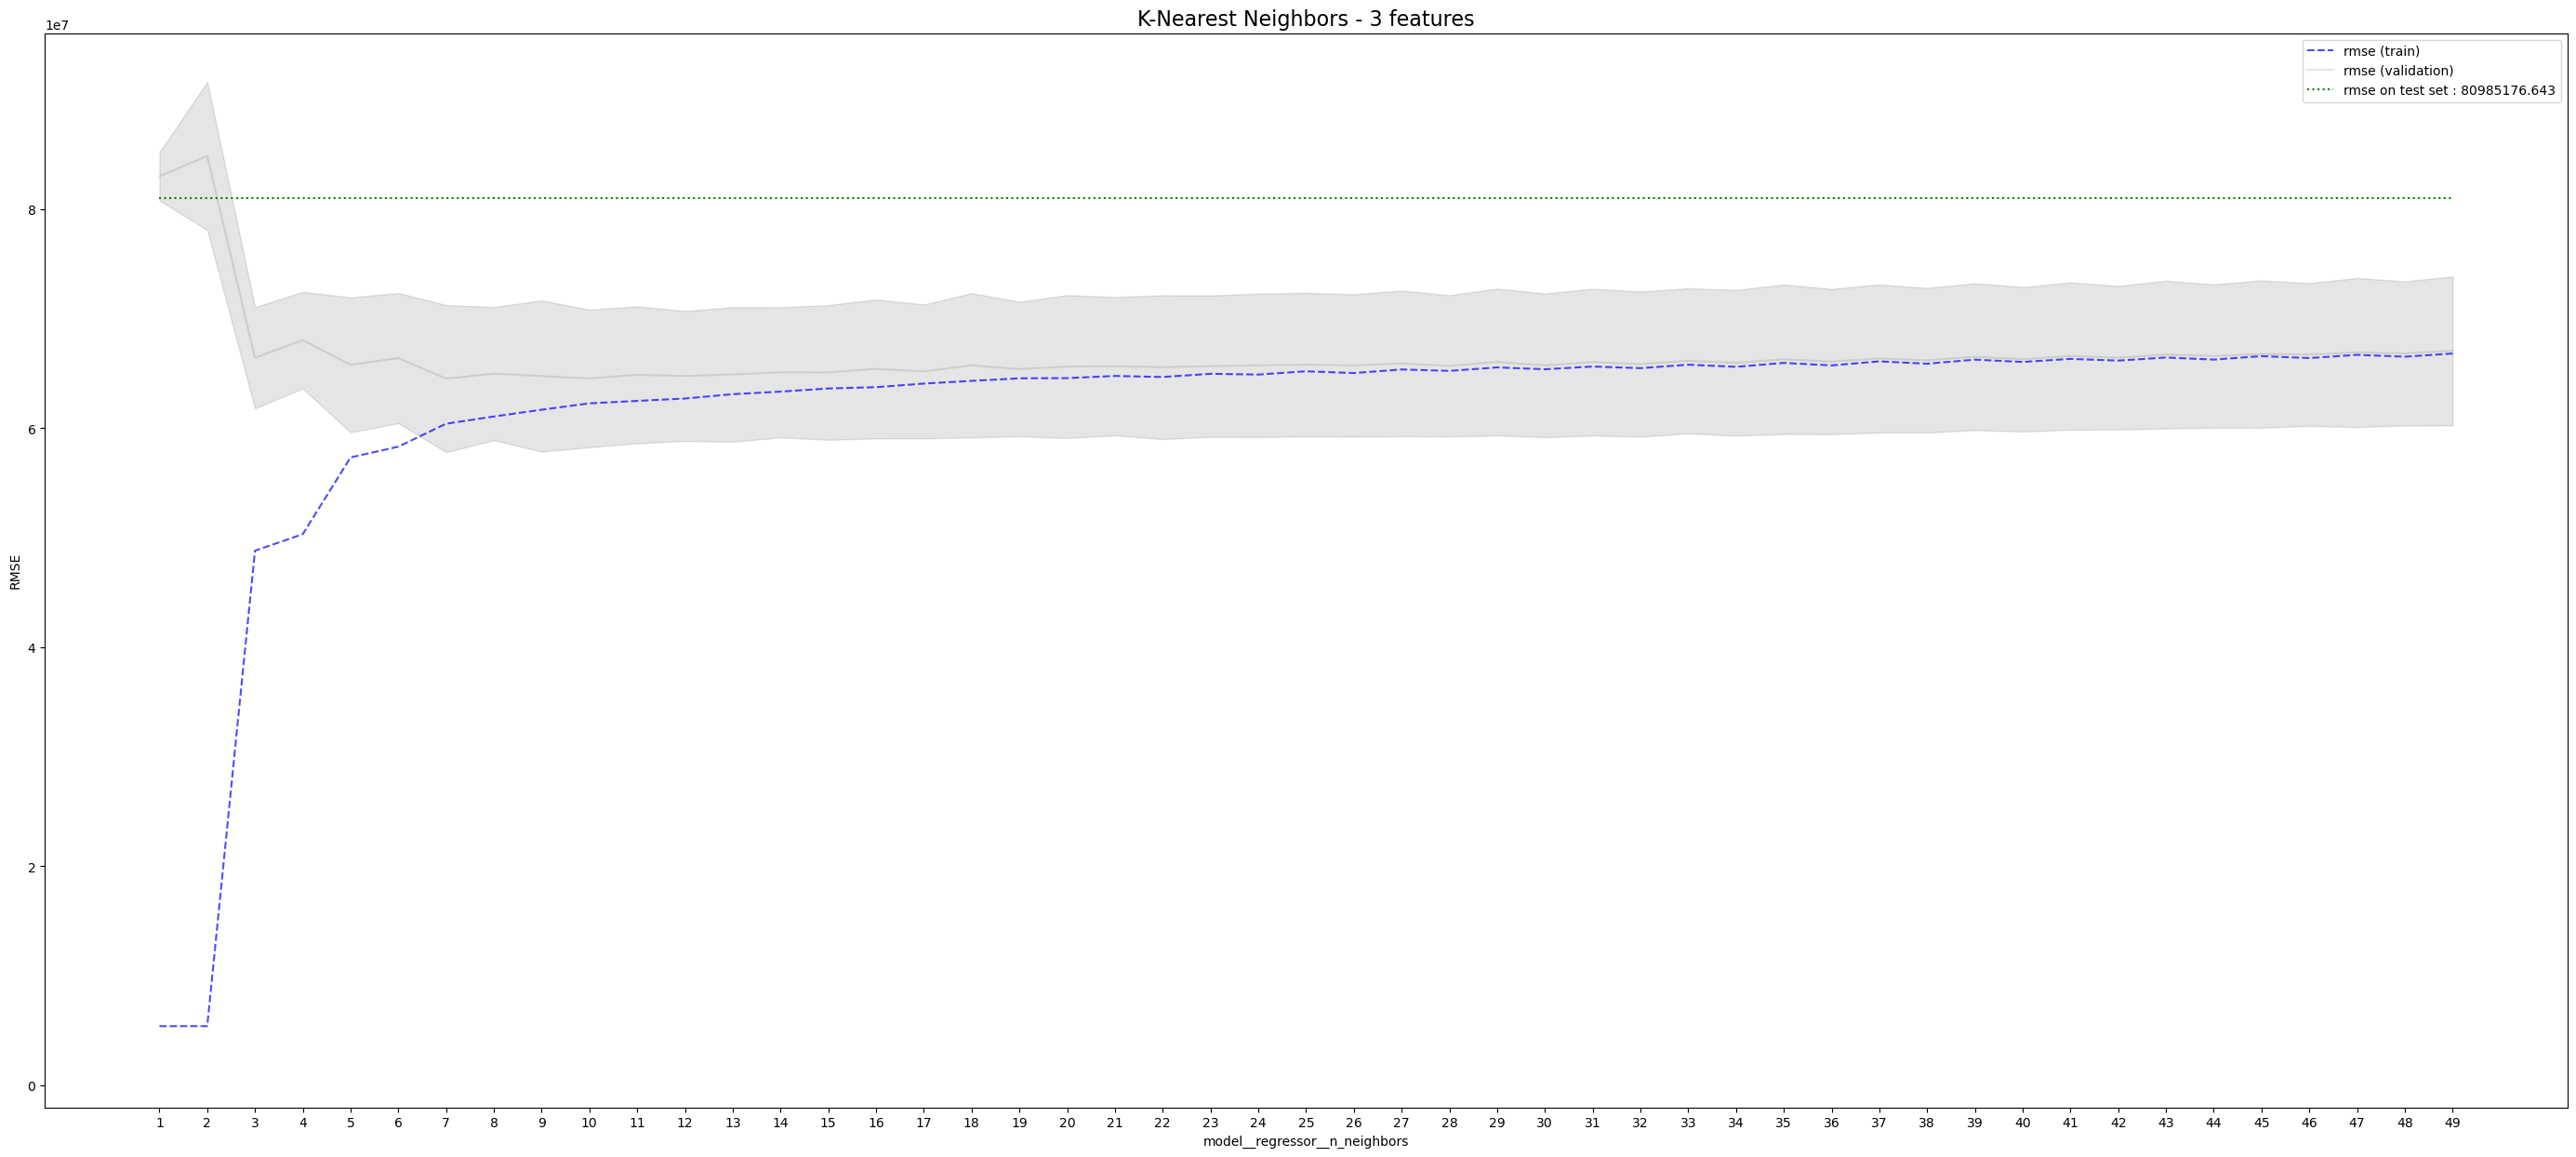

In [26]:
evaluate_model(KNN, knn_results, filename="knn_eval1")

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 3 features


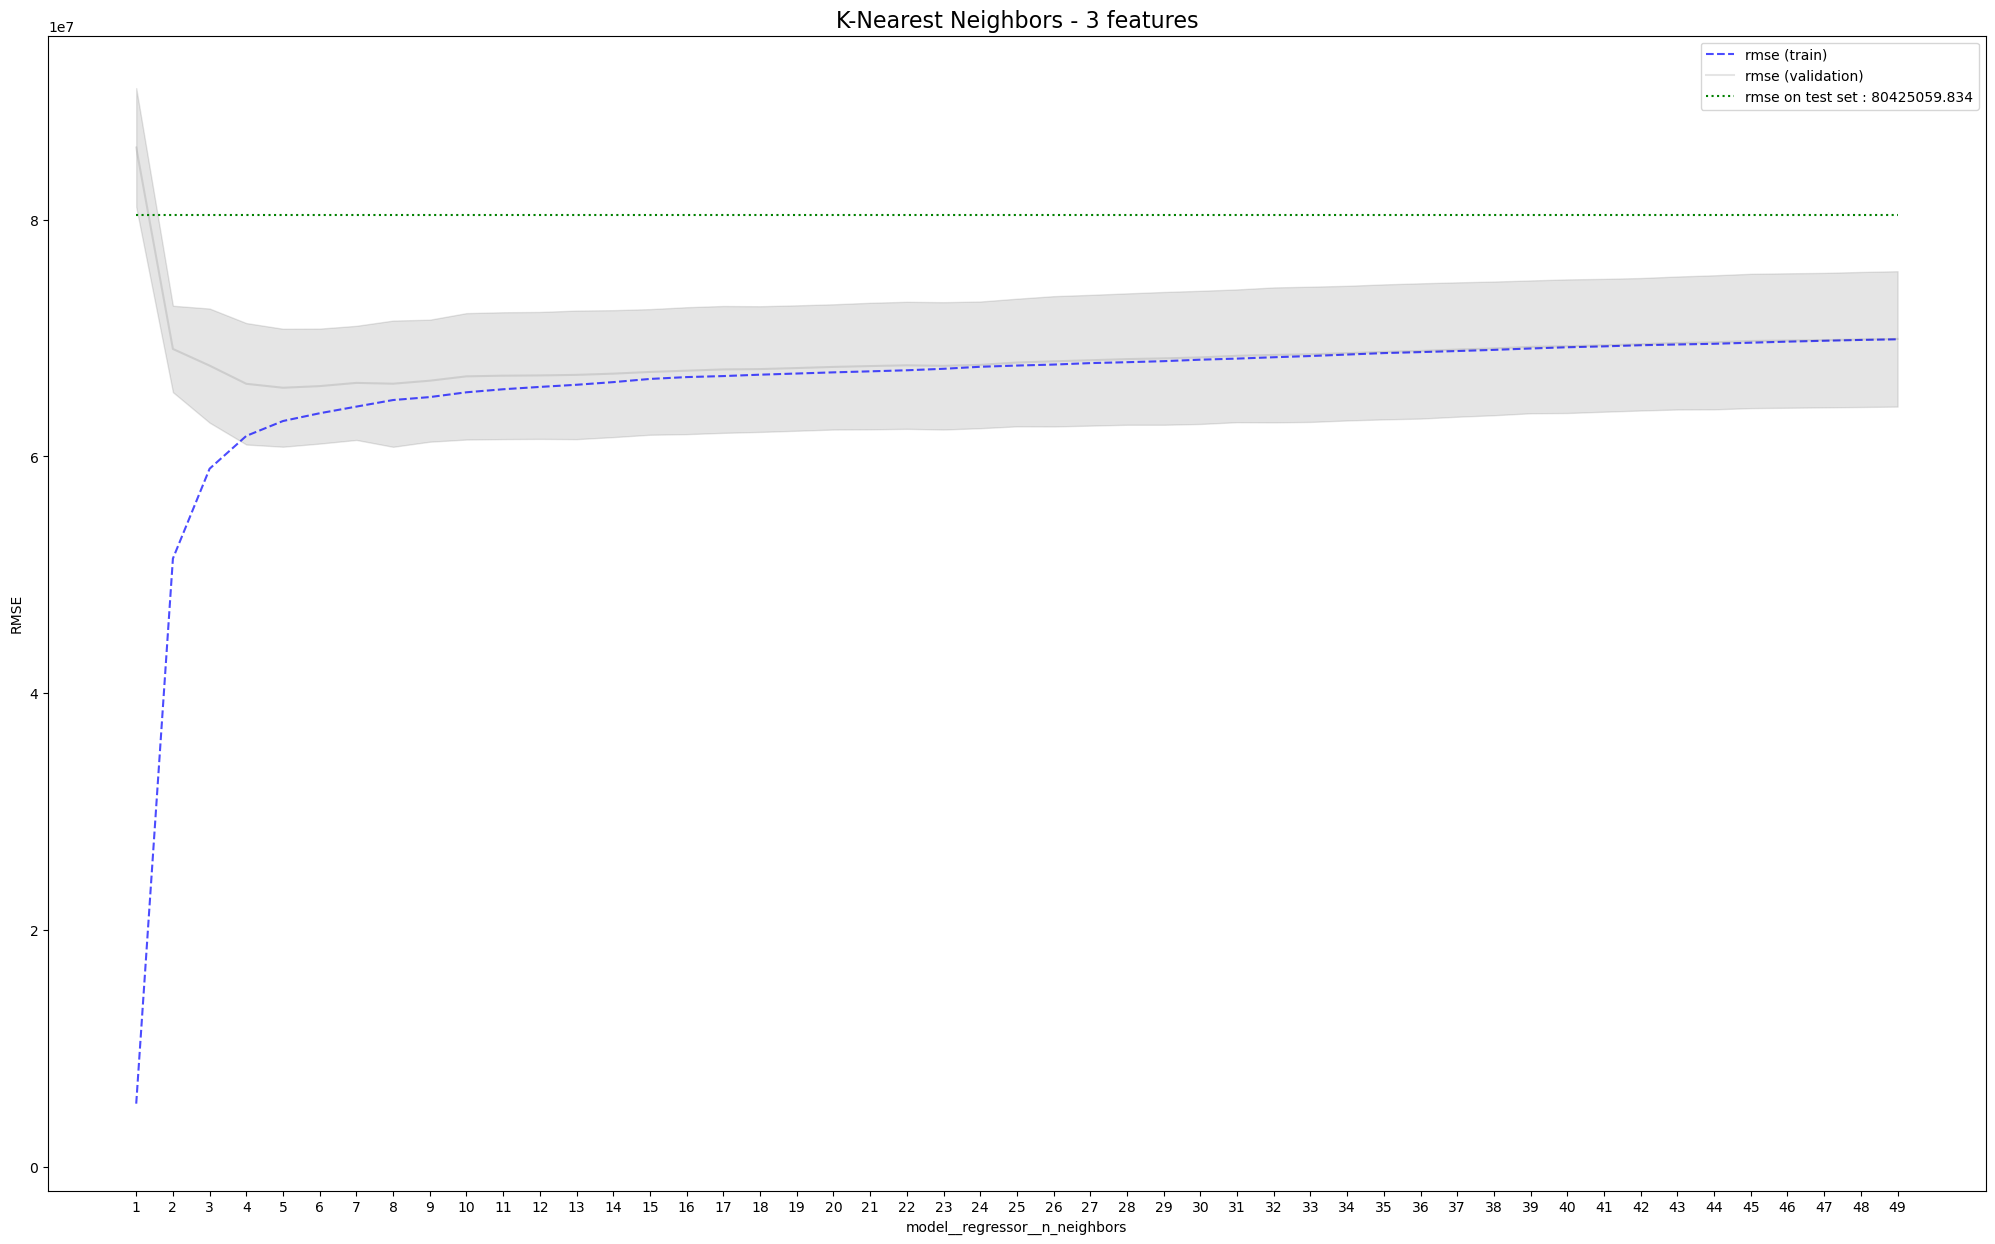

In [23]:
evaluate_model_val_curve(KNN, knn_results, filename="knn_eval1")

In [24]:
knn_results["hyperparameters"][np.argmin(knn_results["test_scores"])]

{'model__regressor__n_neighbors': 5,
 'model__regressor__p': 2,
 'model__regressor__weights': 'uniform'}

In [25]:
print("+" * 25)
print("K-Nearest Neighbors")
print("+" * 25)

KNN_pipe = Pipeline([
	("model", TransformedTargetRegressor(regressor=KNeighborsRegressor(), func=np.log1p, inverse_func=np.expm1))
])

KNN = {
	"name": "K-Nearest Neighbors",
	"instance": KNN_pipe,
	"hyperparameters": {
		"model__regressor__n_neighbors": np.arange(7, 50, 1, dtype=int),
		"model__regressor__p": [1, 2],
		# distance weights make the model overfit a lot
		"model__regressor__weights": ["uniform"]
	},
	#"n_iter": 12,
	"validation_param": "model__regressor__n_neighbors"
}

knn_results2 = tune_model(model=KNN, search_type="gs", k_candidates=[3, 5, 7, 9, 11, 13, 15])

+++++++++++++++++++++++++
K-Nearest Neighbors
+++++++++++++++++++++++++
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 3 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 5 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 7 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 9 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 11 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 13 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 15 fea

In [26]:
pd.DataFrame.from_dict(knn_results2)

,features_kepts,features,best_estimators,hyperparameters,val_scores,test_scores,best_iter_indexes,cv_results
0,3,"[n_votes, runtime, release_year]",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 8, 'model__r...",6.614451e+07,8.036358e+07,3,"{'mean_fit_time': [0.003258800506591797, 0.003..."
1,5,"[n_votes, runtime, release_year, studio_WB, ge...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 7, 'model__r...",6.642669e+07,8.166615e+07,1,"{'mean_fit_time': [0.0031850337982177734, 0.00..."
2,7,"[n_votes, runtime, release_year, studio_BV, st...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 7, 'model__r...",6.572766e+07,8.124692e+07,1,"{'mean_fit_time': [0.0030347347259521485, 0.00..."
3,9,"[n_votes, runtime, release_year, studio_Uni., ...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 7, 'model__r...",6.997628e+07,8.481428e+07,0,"{'mean_fit_time': [0.003141975402832031, 0.003..."
4,11,"[n_votes, runtime, release_year, studio_Uni., ...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 7, 'model__r...",6.980713e+07,8.541137e+07,0,"{'mean_fit_time': [0.003327751159667969, 0.003..."
5,13,"[n_votes, runtime, release_year, studio_Uni., ...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 7, 'model__r...",7.691331e+07,9.440823e+07,0,"{'mean_fit_time': [0.0038735389709472655, 0.00..."
6,15,"[n_votes, runtime, release_year, studio_Uni., ...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 7, 'model__r...",7.677552e+07,9.440784e+07,0,"{'mean_fit_time': [0.00384373664855957, 0.0039..."


-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 3 features


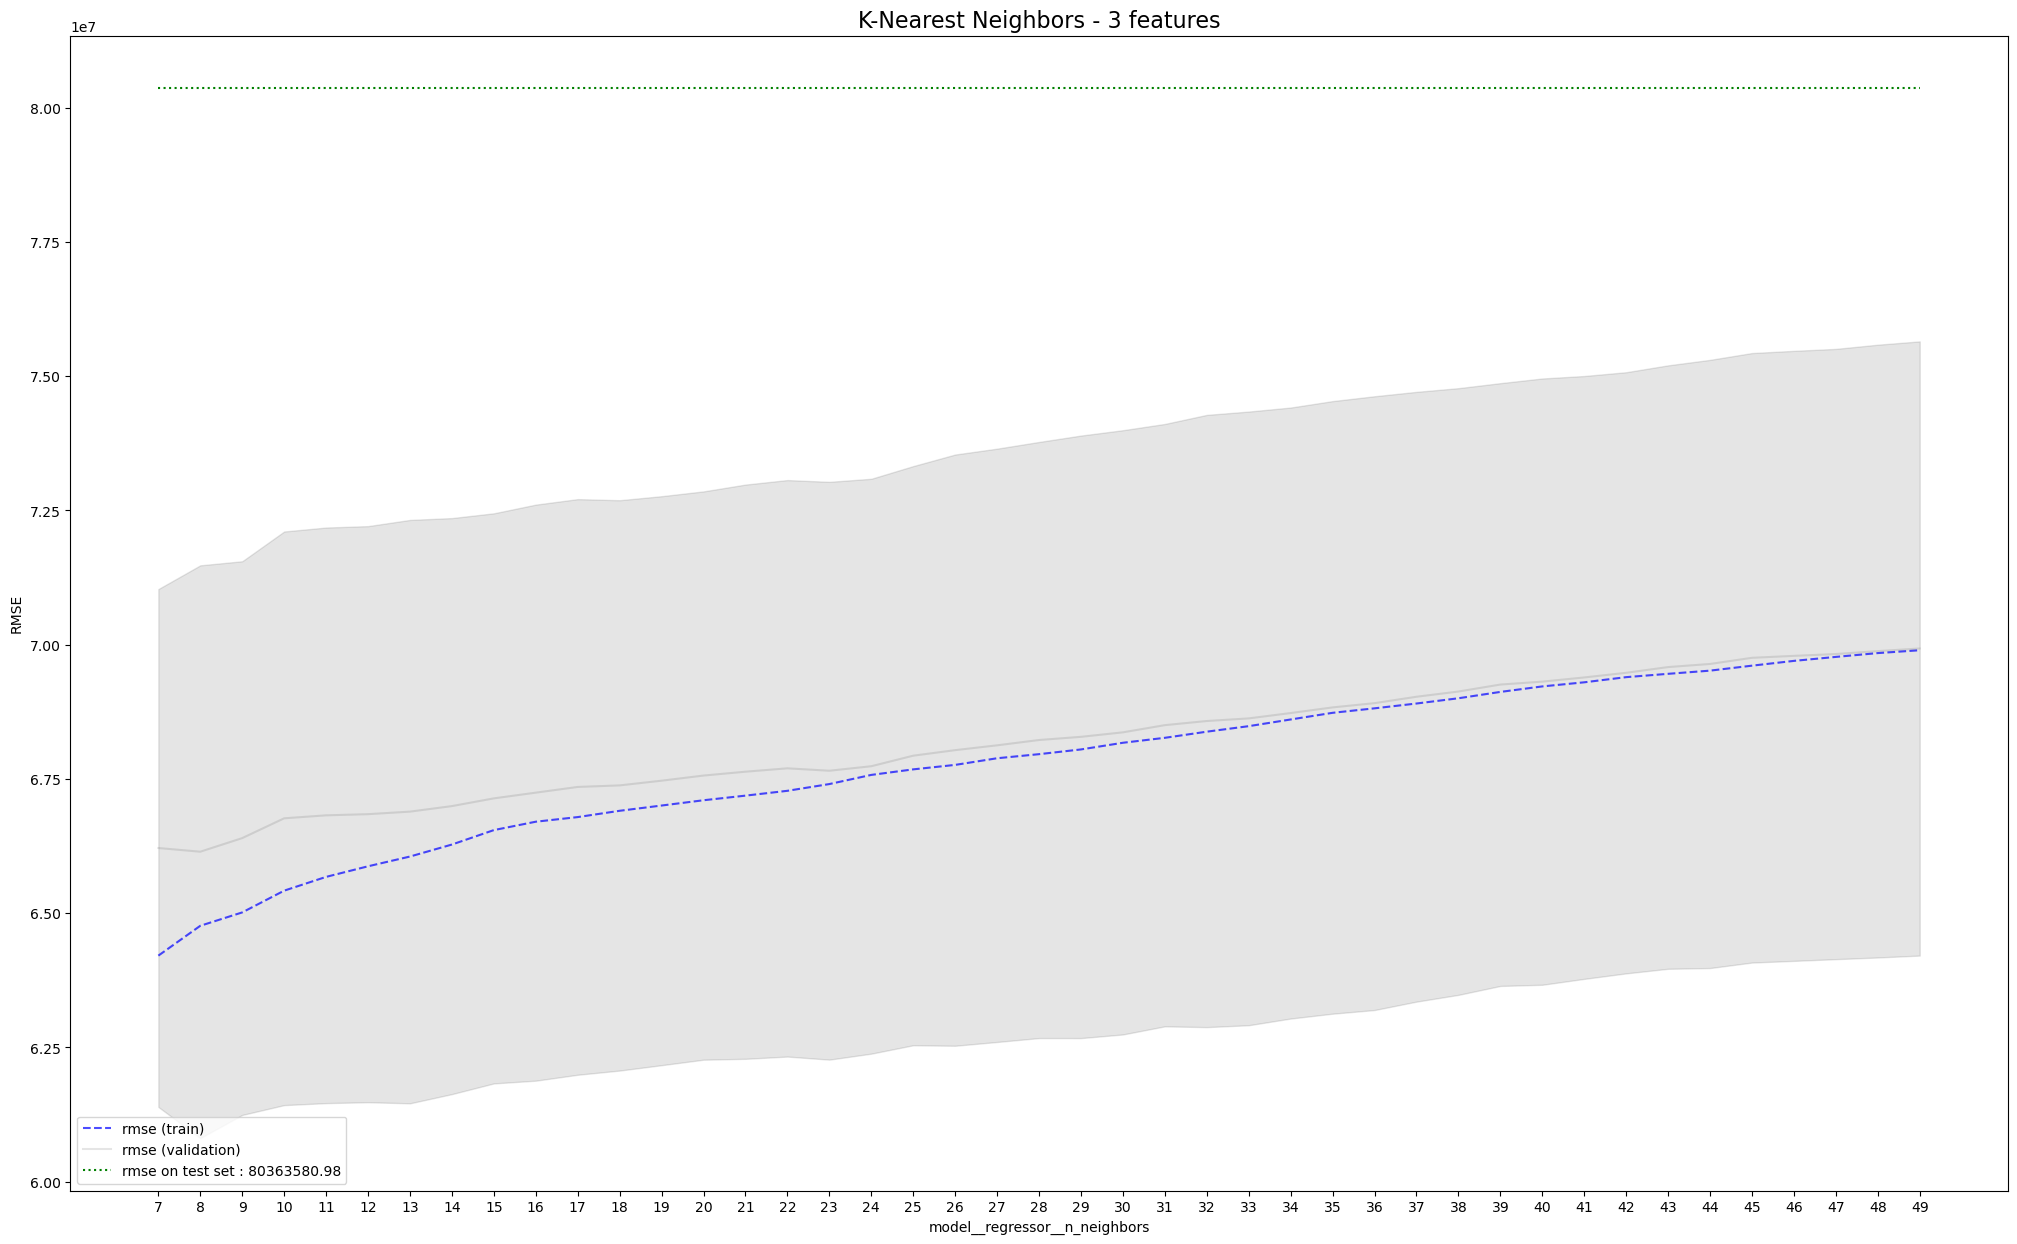

In [27]:
evaluate_model_val_curve(KNN, knn_results2, filename="knn_eval2")

In [34]:
knn_results2["hyperparameters"][np.argmin(knn_results2["test_scores"])]

{'model__regressor__n_neighbors': 8,
 'model__regressor__p': 2,
 'model__regressor__weights': 'uniform'}

### Multi-Layer Perceptron

In [32]:
MLP_pipe = Pipeline([
	("model", TransformedTargetRegressor(regressor=MLPRegressor(), func=np.log1p, inverse_func=np.expm1))
])

MLP = {
	"name": "Multi-Layer Perceptron",
	"instance": MLP_pipe,
	"hyperparameters": {
		# doesn't seem to need to go over 3 layers
		"model__regressor__hidden_layer_sizes": [(10,),(25,),(50,),(75,),(100,),(25,25),(50,25),(50,50),(100,50),(100,75),(100,50,25),(50,25,25,10),(100,75,50,25),],
		# thanh seems the best
		"model__regressor__activation": ["tanh"], #["identity", "logistic", "tanh", "relu"],
		# stick to adam solver since sgd gives overflow
		"model__regressor__solver": ["adam"],
		# 1e-01 seems the best
		"model__regressor__alpha": [1e-05], #[1e-01, 1e-02, 1e-03, 1e-04, 1e-05, 1e-06], # https://scikit-learn.org/stable/modules/neural_networks_supervised.html
		# adam solver only support constant learning rate
		"model__regressor__learning_rate": ["constant"],
		"model__regressor__learning_rate_init": [0.001], #10.0 ** -np.arange(0, 5),
		"model__regressor__max_iter": [200]
	},
	#"n_iter": 12,
	"validation_param": "model__regressor__hidden_layer_sizes"
}

# bayesian search does not support tuple for hyperparameters search
# fallback to grid search
mlp_results = tune_model(model=MLP, search_type="gs", k_candidates=[5, 15, 25, 35, "all"])

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 5 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converge

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 15 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converge

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 25 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converge

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 35 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converge

In [33]:
pd.DataFrame.from_dict(mlp_results)

,features_kepts,features,best_estimators,hyperparameters,val_scores,test_scores,best_iter_indexes,cv_results
0,5,"[n_votes, runtime, release_year, studio_WB, ge...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__activation': 'tanh', 'mode...",6.674313e+07,8.096502e+07,9,"{'mean_fit_time': [0.6560296535491943, 0.92523..."
1,15,"[n_votes, runtime, release_year, studio_Uni., ...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__activation': 'tanh', 'mode...",6.367112e+07,7.647999e+07,8,"{'mean_fit_time': [0.7247876644134521, 1.04319..."
2,25,"[n_votes, runtime, release_year, studio_MGM, s...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__activation': 'tanh', 'mode...",6.716392e+07,8.272130e+07,7,"{'mean_fit_time': [0.796582841873169, 1.214330..."
3,35,"[n_votes, runtime, release_year, studio_MGM, s...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__activation': 'tanh', 'mode...",6.674118e+07,8.637938e+07,1,"{'mean_fit_time': [0.9469177722930908, 1.28500..."
4,all,"[ratings, n_votes, runtime, release_year, stud...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__activation': 'tanh', 'mode...",6.739441e+07,8.289220e+07,1,"{'mean_fit_time': [1.0941190719604492, 1.50029..."


In [ ]:
evaluate_model(MLP, mlp_results, filename="mlp_eval1")

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 15 features


/var/folders/l6/8s1fvb2x2kv47nlbcr_8hsc80000gn/T/ipykernel_8182/3617123835.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_ticks = np.array(hyperparameters[param_name])
/var/folders/l6/8s1fvb2x2kv47nlbcr_8hsc80000gn/T/ipykernel_8182/3617123835.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_scores, val_scores = validation_curve(best_estimator, X_train, y_train, param_name=param_name, param_range=np.array(hyperparameters[param_name]), cv=kf, scoring=rmse, error_score=0, n_jobs=-1)
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/

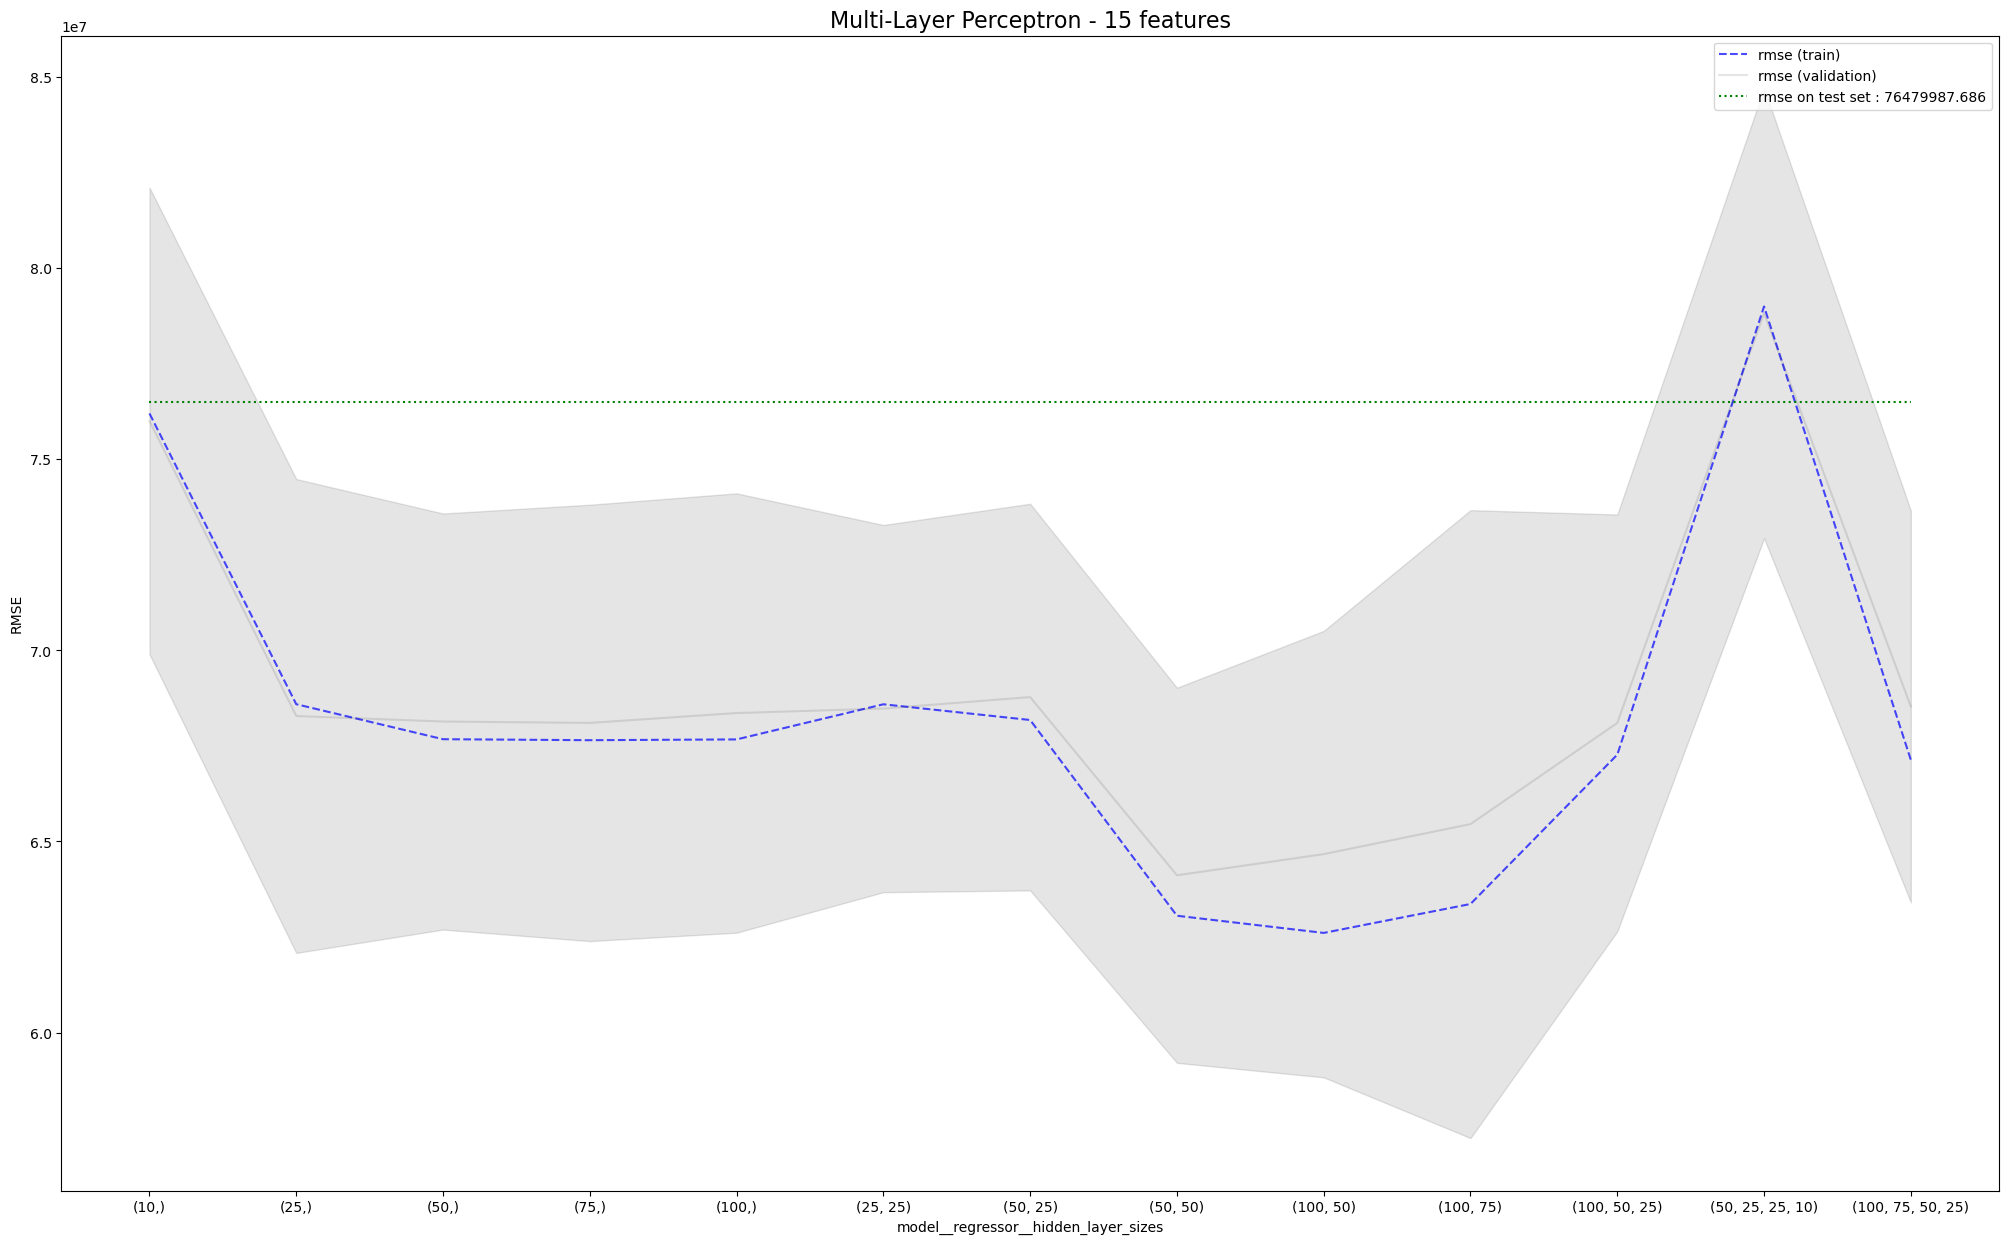

In [35]:
evaluate_model_val_curve(MLP, mlp_results, filename="mlp_eval1")

In [36]:
mlp_results["hyperparameters"][np.argmin(mlp_results["test_scores"])]

{'model__regressor__activation': 'tanh',
 'model__regressor__alpha': 1e-05,
 'model__regressor__hidden_layer_sizes': (100, 50),
 'model__regressor__learning_rate': 'constant',
 'model__regressor__learning_rate_init': 0.001,
 'model__regressor__max_iter': 200,
 'model__regressor__solver': 'adam'}

In [46]:
MLP_pipe = Pipeline([
	("model", TransformedTargetRegressor(regressor=MLPRegressor(), func=np.log1p, inverse_func=np.expm1))
])

MLP = {
	"name": "Multi-Layer Perceptron",
	"instance": MLP_pipe,
	"hyperparameters": {
		# doesn't seem to need to go over 3 layers
		"model__regressor__hidden_layer_sizes": [(10,),(25,),(50,),(75,),(100,),(25,25),(50,25),(50,50),(100,50),(100,75),(100,50,25),(50,25,25,10),(100,75,50,25),],
		# thanh seems the best
		"model__regressor__activation": ["tanh"], #["identity", "logistic", "tanh", "relu"],
		# stick to adam solver since sgd gives overflow
		"model__regressor__solver": ["adam"],
		# 1e-01 seems the best
		"model__regressor__alpha": [1e-05], #[1e-01, 1e-02, 1e-03, 1e-04, 1e-05, 1e-06], # https://scikit-learn.org/stable/modules/neural_networks_supervised.html
		# adam solver only support constant learning rate
		"model__regressor__learning_rate": ["constant"],
		"model__regressor__learning_rate_init": [0.001], #10.0 ** -np.arange(0, 5),
		"model__regressor__max_iter": [2500]
	},
	#"n_iter": 12,
	"validation_param": "model__regressor__hidden_layer_sizes"
}

# bayesian search does not support tuple for hyperparameters search
# fallback to grid search
mlp_results2 = tune_model(model=MLP, search_type="gs", k_candidates=[5, 15, 25, 35, "all"])

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 5 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
pd.DataFrame.from_dict(mlp_results2)

In [ ]:
evaluate_model(MLP, mlp_results2, filname="mlp_eval2")

### Random Forest

#### Tuning

In [51]:
random_forest_pipe = Pipeline([
	("model", TransformedTargetRegressor(regressor=RandomForestRegressor(random_state=42), func=np.log1p, inverse_func=np.expm1))
])

rf = {
	"name": "Random Forest",
	"instance": random_forest_pipe,
	"hyperparameters": {
		"model__regressor__n_estimators": [100, 200, 300, 400, 500],
		#"model__regressor__criterion": ["absolute_error"], #["absolute_error", "squared_error"],
		"model__regressor__max_depth": [80, 90, 100, 110, 120, 130, 140, 150, None], # none means unbounded max depth
		"model__regressor__min_samples_split": [5, 10, 15],
		"model__regressor__min_samples_leaf": [1, 2, 4],
		"model__regressor__bootstrap": [True, False],
		"model__regressor__max_features": ["auto", "log2", "sqrt"]
	},
	"n_iter": 30,
	"validation_param": "model__regressor__n_estimators"
}

rf_results = tune_model(model=rf, search_type="bs", k_candidates=[5, 10, 15, 20, 25])

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 5 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 10 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 15 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 20 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 25 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or

In [52]:
pd.DataFrame.from_dict(rf_results)

,features_kepts,features,best_estimators,hyperparameters,val_scores,test_scores,best_iter_indexes,cv_results
0,5,"[n_votes, runtime, release_year, studio_WB, ge...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__bootstrap': False, 'model_...",6.390937e+07,8.131738e+07,0,"{'mean_fit_time': [0.9138559818267822, 0.21282..."
1,10,"[n_votes, runtime, release_year, studio_Uni., ...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__bootstrap': True, 'model__...",6.333563e+07,7.785322e+07,14,"{'mean_fit_time': [1.028454351425171, 0.255681..."
2,15,"[n_votes, runtime, release_year, studio_Uni., ...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__bootstrap': True, 'model__...",6.267816e+07,7.816450e+07,17,"{'mean_fit_time': [1.1839240550994874, 0.23159..."
3,20,"[n_votes, runtime, release_year, studio_MGM, s...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__bootstrap': True, 'model__...",6.316179e+07,7.741856e+07,13,"{'mean_fit_time': [1.5697378158569335, 0.34021..."
4,25,"[n_votes, runtime, release_year, studio_MGM, s...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__bootstrap': True, 'model__...",6.271352e+07,7.774042e+07,25,"{'mean_fit_time': [1.4997725009918212, 0.27284..."


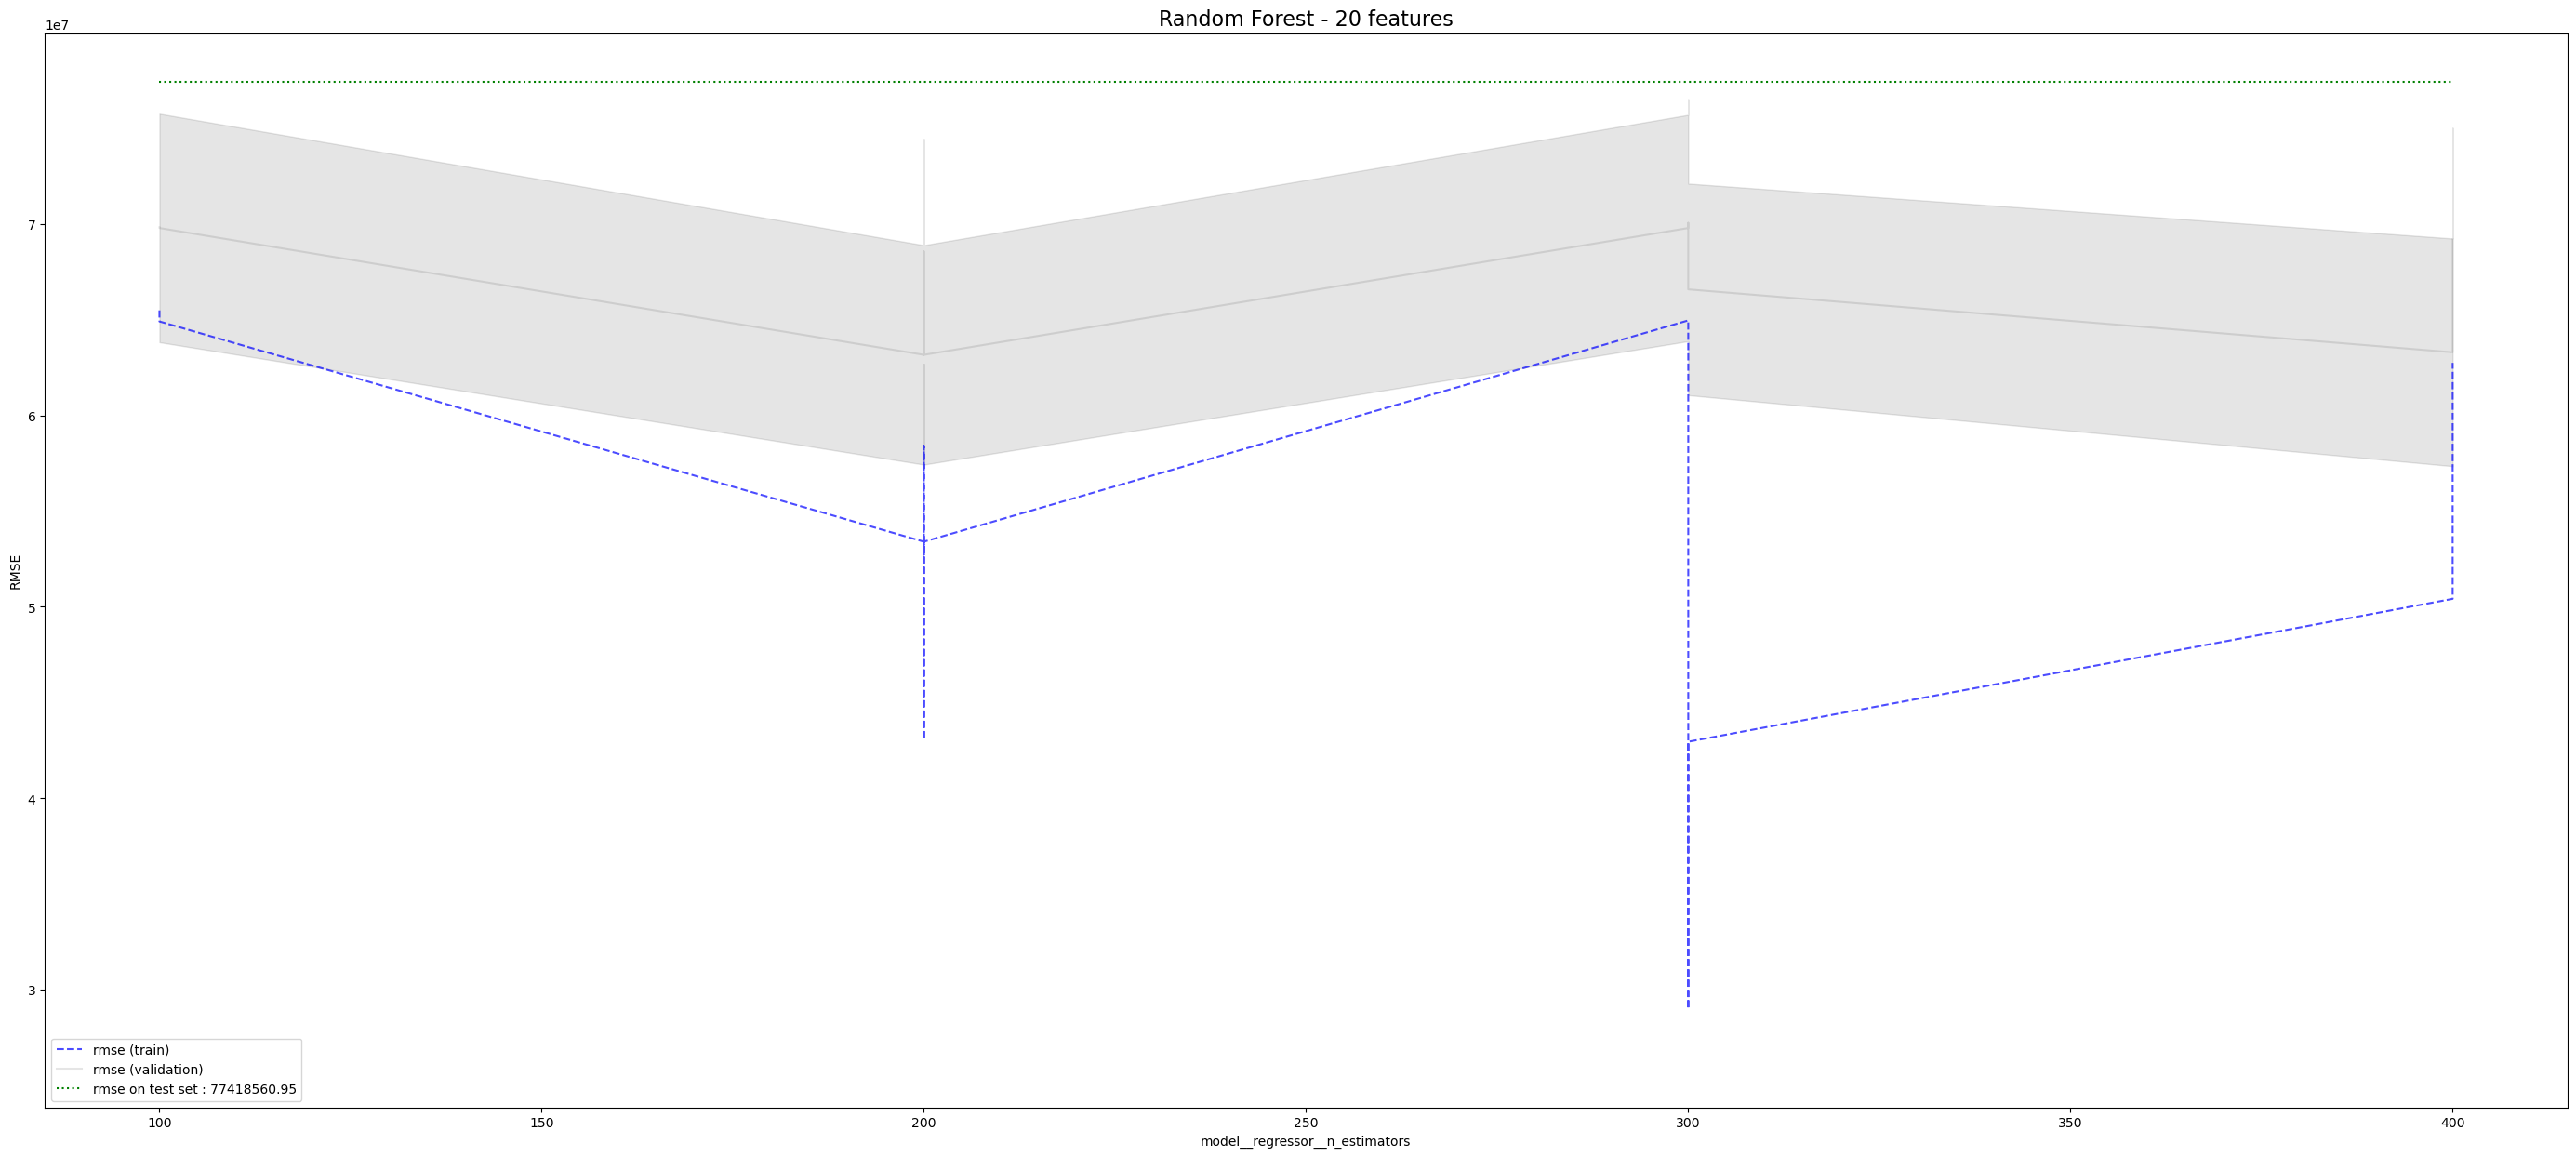

In [54]:
evaluate_model(rf, rf_results, filename="rf_eval")

In [55]:
rf_results["hyperparameters"][np.argmin(rf_results["test_scores"])]

OrderedDict([('model__regressor__bootstrap', True),
             ('model__regressor__max_depth', 100),
             ('model__regressor__max_features', 'auto'),
             ('model__regressor__min_samples_leaf', 2),
             ('model__regressor__min_samples_split', 10),
             ('model__regressor__n_estimators', 200)])

In [ ]:
evaluate_model_val_curve(rf, rf_results)

## Prediction

We're gonna make prediction about the revenue of movies present in `X2.csv`.

['n_votes', 'runtime', 'release_year', 'studio_Uni.', 'studio_Fox', 'studio_BV', 'studio_Par.', 'studio_WB', 'studio_SPC', 'studio_Sony', 'genre_Action', 'genre_Adventure', 'img_feature1', 'img_feature4', 'text_feature2']


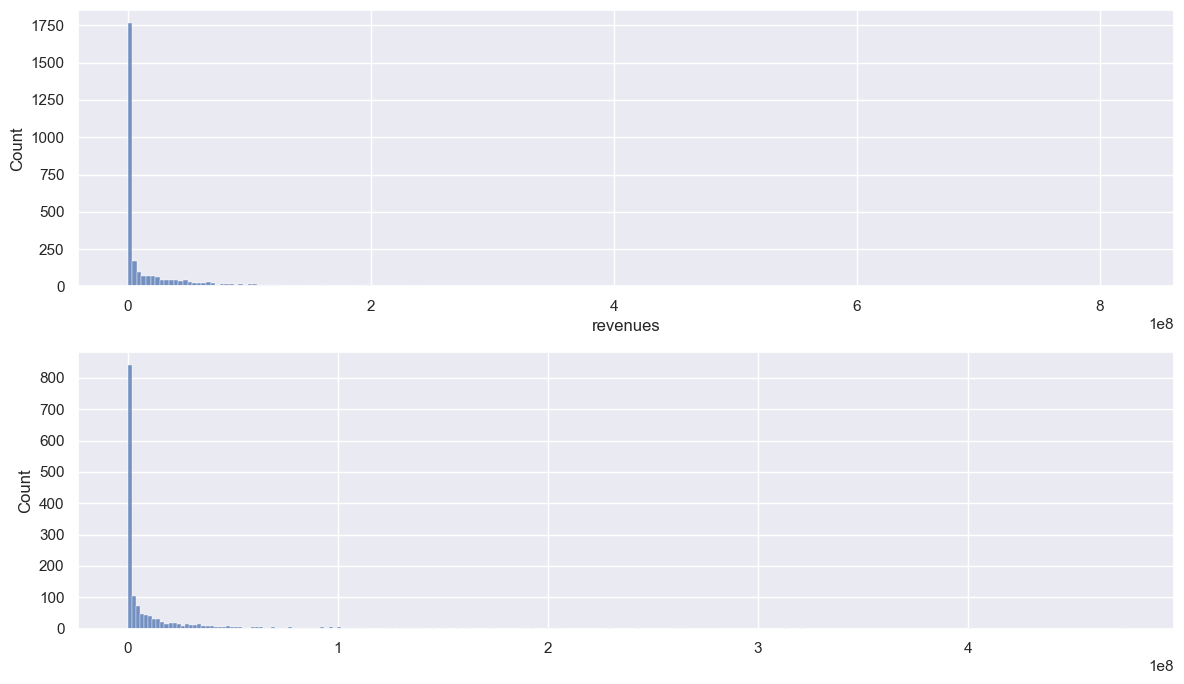

In [57]:
fig, ax = plt.subplots(2, figsize=(12,7))
sns.set(rc={"figure.figsize": (9, 14)})

best_model = mlp_results["best_estimators"][np.argmin(mlp_results["test_scores"])]
features = mlp_results["features"][np.argmin(mlp_results["test_scores"])]
print(features)

assert len(X2) == 1518

Y2 = best_model.predict(X2[features].fillna(0))

sns.histplot(Y, ax=ax[0])
sns.histplot(Y2, ax=ax[1])
fig.tight_layout()

plt.savefig("report/figures/prediction_histogram.pdf", dpi=300)

In [59]:
np.insert(Y2, Y2.size, mlp_results["test_scores"][np.argmin(mlp_results["test_scores"])])

array([2.01550824e+06, 2.48914061e+04, 2.24992627e+04, ...,
       3.30276901e+07, 2.07442628e+04, 7.64799877e+07])

In [60]:
pd.DataFrame(Y2.T).to_csv("results/Y2.csv", header=False, index=False)

In [77]:
X2

,ratings,n_votes,production_year,runtime,release_year,studio_other,studio_MGM,studio_NL,studio_IFC,studio_Mira.,studio_Uni.,studio_Fox,studio_BV,studio_Par.,studio_WB,studio_Magn.,studio_Strand,studio_SPC,studio_Lions,studio_Orion,studio_Col.,studio_Gold.,studio_Sony,studio_FoxS,studio_Eros,...,genre_Horror,genre_Animation,genre_Biography,genre_Music,genre_Sci-Fi,genre_History,genre_Sport,genre_War,genre_Short,genre_Western,genre_Musical,genre_Reality-TV,genre_Game-Show,genre_News,genre_Film-Noir,img_feature0,img_feature1,img_feature2,img_feature3,img_feature4,text_feature0,text_feature1,text_feature2,text_feature3,text_feature4
0,0.927681,0.979580,0.556049,0.403114,0.247756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.954623,-7.470569,3.429703,3.296277,-1.269257,-2.825935,-8.606529,1.560678,1.297445,0.571073
1,-0.456942,-1.198868,-2.794771,-2.581643,1.748274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-15.529811,8.100534,-1.284303,-5.322762,-7.946449,-35.848660,14.900857,-1.024711,7.351847,0.693490
2,-0.110787,-1.926547,-3.396200,-1.984692,0.890835,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-3.262370,-9.426272,-8.326006,2.586226,10.341563,10.927055,0.389749,-7.344590,5.788484,0.205509
3,1.273837,-1.020111,-2.107423,-1.042137,0.354936,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,17.696562,13.998174,-6.026592,4.991468,5.471656,29.220103,3.787307,1.777825,-2.262948,1.002776
4,-0.543481,-0.028915,-0.217217,0.371695,-0.716862,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,-19.156470,3.590392,6.889032,18.200164,-6.829449,6.932150,-3.122498,-2.065650,-0.568640,-4.962003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513,-1.062715,-0.376725,-0.818647,-0.225256,-1.359941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.111186,-10.742327,-3.677359,-8.980802,-2.623461,-12.007367,-0.981857,-7.564573,3.812941,1.954593
1514,1.533453,-1.683987,-2.537016,-1.042137,1.641094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21.991487,7.611070,5.272339,-4.352788,-5.854521,28.005083,-2.178713,8.905717,3.915719,4.238328
1515,0.062291,0.612470,0.212375,0.088929,-0.180963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-4.086628,8.765723,-2.926365,-8.918505,-5.536660,20.137483,-7.088496,-4.121805,0.564443,2.738837
1516,0.148830,1.389172,0.298293,0.717299,-0.073783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,-3.196285,-11.187750,1.326027,8.055748,7.469347,-2.635573,-0.260180,-2.554256,-3.797431,1.889937
